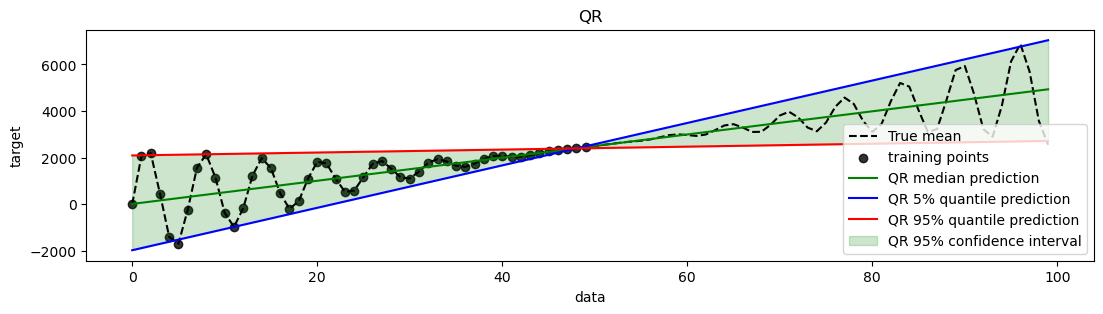

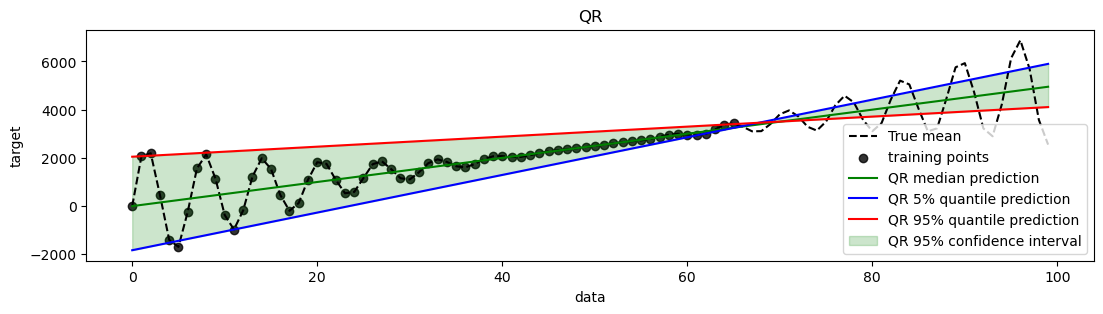

In [5]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import QuantileRegressor
from sklearn.model_selection import train_test_split


def main():
    figsize = (13, 3)
    demo(N=100, train_size=50, figsize=figsize)
    demo(N=100, train_size=66, figsize=figsize)


def demo(N, train_size, figsize=(14, 6)):
    X = np.arange(N).reshape(-1, 1)
    scale = 50  # N / 2  # 50
    shift = 50  # N / 3  # 50
    y = scale * X + (X-shift)**2 * np.sin(X)
    y = y.squeeze()

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, shuffle=False, random_state=42)

    qrs = fit_qrs(X_train, y_train, ci_alpha=0.1, qr_alpha=0.0)
    y_preds, y_pis = estimate_quantiles(X, qrs)

    plot_intervals(X, y, X_train, y_train, y_preds, y_pis, figsize)


def fit_qrs(X_train, y_train, ci_alpha=0.1, qr_alpha=0.0):
    quant_min = ci_alpha / 2
    quant_median = 0.5
    quant_max = 1 - quant_min

    qrs = {}
    for quantile in [quant_min, quant_median, quant_max]:
        qr = QuantileRegressor(quantile=quantile, alpha=qr_alpha)
        qr_fit = qr.fit(X_train, y_train)
        qrs[quantile] = qr_fit
    return qrs


def estimate_quantiles(X_test, qrs):
    quant_min, quant_median, quant_max = sorted(qr.quantile for qr in qrs.values())
    predictions = {}
    for quantile, qr in qrs.items():
        y_pred = qr.predict(X_test)
        predictions[quantile] = y_pred
    y_preds = predictions[quant_median]
    y_pis = np.stack([predictions[quant_min], predictions[quant_max]], axis=1)  # (n_samples, 2)
    return y_preds, y_pis


def plot_intervals(X, y, X_train, y_train, y_preds, y_pis, figsize=(14, 6)):
    num_train_steps = X_train.shape[0]
    num_steps_total = X.shape[0]
    x_plot_train = np.arange(num_train_steps)
    x_plot_full = np.arange(num_steps_total)

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(x_plot_full, y, color="black", linestyle="dashed", label="True mean")

    plt.scatter(
        x_plot_train,
        y_train,
        color="black",
        marker="o",
        alpha=0.8,
        label="training points",
    )

    ax.plot(x_plot_full, y_preds, label="QR median prediction", color='green')
    ax.plot(x_plot_full, y_pis[:, 0], label="QR 5% quantile prediction", color='blue')
    ax.plot(x_plot_full, y_pis[:, 1], label="QR 95% quantile prediction", color='red')
    ax.fill_between(
        x_plot_full.ravel(),
        y_pis[:, 0],
        y_pis[:, 1],
        color='green',
        alpha=0.2,
        label=r"QR 95% confidence interval",
    )

    plt.legend()
    plt.xlabel("data")
    plt.ylabel("target")
    plt.title("QR")
    plt.show()


def plot_data(X_train, X_test, y_train, y_test):
    """visualize training and test sets"""
    # todo: extract
    num_train_steps = X_train.shape[0]
    num_test_steps = X_test.shape[0]

    x_plot_train = np.arange(num_train_steps)
    x_plot_test = x_plot_train + num_test_steps

    plt.figure(figsize=(16, 5))
    plt.plot(x_plot_train, y_train)
    plt.plot(x_plot_test, y_test)
    plt.legend(["Training data", "Test data"])
    plt.show()


if __name__ == '__main__':
    main()